# 05 — Final Modeling Tabular

## Baselines + Models


In [1]:
from pathlib import Path
import os, json, math, time, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, backend as K

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.integration import TFKerasPruningCallback
from optuna.storages import JournalStorage, JournalFileStorage
from optuna.storages.journal._file import JournalFileOpenLock

2025-11-17 10:39:52.471795: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-17 10:39:52.520084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763393992.530285 2430963 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763393992.533742 2430963 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-17 10:39:52.581798: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
USE_MLFLOW = False
if USE_MLFLOW:
    try:
        import mlflow
    except ImportError:
        print("MLflow no está instalado; desactiva USE_MLFLOW o instala mlflow.")
        USE_MLFLOW = False

optuna.logging.set_verbosity(optuna.logging.WARNING)

## Config

In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass
print("TF GPUs:", gpus)

TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [50]:
DATA_CLEAN = Path("../data/clean/base_dataset.csv")
OUT_DIR = Path("../outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
ART_DIR = OUT_DIR / "artifacts_keras/latest"; ART_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUT_DIR / "figures/latest"; FIG_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
TARGET_COL = "GHI"
FREQ = "10T"
DEFAULT_INPUT_STEPS   = 36   # 6h pasado
DEFAULT_HORIZON_STEPS = 6    # 1h adelante

PATIENCE = 8

### Mode

In [6]:
MODE = "AIA"  # "LAPTOP" o "AIA"

if MODE == "LAPTOP":
    N_TRIALS_RF   = 30
    N_TRIALS_LSTM = 40
    N_TRIALS_GRU  = 40
    N_TRIALS_DIL  = 35
    N_TRIALS_CW   = 35
    MAX_EPOCHS    = 60
elif MODE == "AIA":
    N_TRIALS_RF   = 120
    N_TRIALS_LSTM = 120
    N_TRIALS_GRU  = 120
    N_TRIALS_DIL  = 120
    N_TRIALS_CW   = 120
    MAX_EPOCHS    = 90

In [7]:
PRUNER = MedianPruner(n_warmup_steps=5)

### Storage

In [8]:
JOURNAL_PATH = (OUT_DIR / "optuna_tabular_keras.journal").resolve()
LOCK = JournalFileOpenLock(str(JOURNAL_PATH) + ".lock")
STORAGE = JournalStorage(JournalFileStorage(str(JOURNAL_PATH), lock_obj=LOCK))

In [9]:
def prepare_journal_storage(study_name: str) -> JournalStorage:
    log_path = (OUT_DIR / f"{study_name}.log").resolve()
    lock     = JournalFileOpenLock(str(log_path) + ".lock")
    return JournalStorage(JournalFileStorage(str(log_path), lock_obj=lock))

## Data

In [10]:
df = pd.read_csv(DATA_CLEAN, parse_dates=[0], index_col=0).sort_index()
df.index.name = "time"

base_feats = [
    'Presion','TempAmb','WindSpeed','WindDirection',
    'hour_sin','hour_cos','DoY Sin','DoY Cos',
    'solar_zenith','solar_azimuth','solar_elevation',
    'TempAmb_roll1h_mean','TempAmb_roll6h_mean',
    'Presion_roll1h_mean','Presion_roll6h_mean',
    'WindSpeed_roll1h_mean','WindSpeed_roll6h_mean',
    'temp_pressure_ratio','wind_temp_interaction'
]
ghi_lags  = [c for c in ['GHI_lag1','GHI_lag3','GHI_lag6','GHI_lag12','GHI_lag36'] if c in df.columns]
ghi_rolls = [c for c in ['GHI_roll1h_mean','GHI_roll3h_mean','GHI_roll6h_mean','GHI_roll1h_max'] if c in df.columns]
feat_cols = [c for c in base_feats if c in df.columns] + ghi_lags + ghi_rolls
print(f"Total features used: {len(feat_cols)}")
print(feat_cols)

Total features used: 28
['Presion', 'TempAmb', 'WindSpeed', 'WindDirection', 'hour_sin', 'hour_cos', 'DoY Sin', 'DoY Cos', 'solar_zenith', 'solar_azimuth', 'solar_elevation', 'TempAmb_roll1h_mean', 'TempAmb_roll6h_mean', 'Presion_roll1h_mean', 'Presion_roll6h_mean', 'WindSpeed_roll1h_mean', 'WindSpeed_roll6h_mean', 'temp_pressure_ratio', 'wind_temp_interaction', 'GHI_lag1', 'GHI_lag3', 'GHI_lag6', 'GHI_lag12', 'GHI_lag36', 'GHI_roll1h_mean', 'GHI_roll3h_mean', 'GHI_roll6h_mean', 'GHI_roll1h_max']


In [11]:
assert TARGET_COL in df.columns, f"TARGET_COL='{TARGET_COL}' no existe en el dataset"
n = len(df); i_tr = int(0.7*n); i_va = int(0.85*n)
df_train, df_val, df_test = df.iloc[:i_tr], df.iloc[i_tr:i_va], df.iloc[i_va:]

X_scaler = StandardScaler(); y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(df_train[feat_cols].values)
X_val   = X_scaler.transform(df_val[feat_cols].values)
X_test  = X_scaler.transform(df_test[feat_cols].values)

y_train = y_scaler.fit_transform(df_train[[TARGET_COL]].values).ravel()
y_val   = y_scaler.transform(df_val[[TARGET_COL]].values).ravel()
y_test  = y_scaler.transform(df_test[[TARGET_COL]].values).ravel()

In [12]:
print("NaNs antes de imputar:",
      np.isnan(X_train).sum(), np.isnan(X_val).sum(), np.isnan(X_test).sum())

NaNs antes de imputar: 144 0 0


In [13]:
imp = SimpleImputer(strategy="median")
X_train = imp.fit_transform(X_train)
X_val   = imp.transform(X_val)
X_test  = imp.transform(X_test)

for name, arr in [("X_train",X_train),("X_val",X_val),("X_test",X_test),
                  ("y_train",y_train),("y_val",y_val),("y_test",y_test)]:
    assert np.isfinite(arr).all(), f"{name} tiene NaN/Inf"


## Helpers

In [14]:
def metrics_from_scaled(pred_scaled, true_scaled, y_scaler):
    p = y_scaler.inverse_transform(pred_scaled.reshape(-1,1)).ravel()
    t = y_scaler.inverse_transform(true_scaled.reshape(-1,1)).ravel()
    mae = mean_absolute_error(t, p)
    rmse = float(np.sqrt(mean_squared_error(t, p)))
    # MAPE corregido (sin +1e-6 en el numerador)
    mape = float(np.mean(np.abs(t - p) / (np.abs(t) + 1e-6)) * 100)
    smape = float(100 * np.mean(2*np.abs(p - t) / (np.abs(t) + np.abs(p) + 1e-6)))
    r2 = float(r2_score(t, p))
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "sMAPE": smape, "R2": r2}, (t, p)

def persistence_baseline(y_scaled, horizon):
    y_hat = np.roll(y_scaled, horizon)
    y_hat[:horizon] = y_scaled[horizon]
    return y_hat

def _rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))

### Sequences

In [15]:
def build_seq_arrays(X_2d, y_1d, L, horizon):
    """
    X_2d: (N, F), y_1d: (N,), L: window len (input_steps), horizon: steps ahead
    Devuelve X_seq (N', L, F), y_seq (N',)
    """
    N, F = X_2d.shape
    outX, outy = [], []
    last = N - L - horizon + 1
    if last <= 0:
        return np.zeros((0, L, F), dtype="float32"), np.zeros((0,), dtype="float32")
    for i in range(last):
        block = X_2d[i:i+L]
        if np.isnan(block).any():
            continue
        outX.append(block)
        outy.append(y_1d[i + L + horizon - 1])
    return np.asarray(outX, dtype="float32"), np.asarray(outy, dtype="float32")

def build_seq_arrays_with_idx(X_2d, y_1d, idx, L, horizon):
    """
    Versión extendida: devuelve también los timestamps de cada muestra de salida.
    """
    N, F = X_2d.shape
    outX, outy, out_idx = [], [], []
    last = N - L - horizon + 1
    if last <= 0:
        return (np.zeros((0, L, F), dtype="float32"),
                np.zeros((0,), dtype="float32"),
                np.array([], dtype="datetime64[ns]"))
    for i in range(last):
        block = X_2d[i:i+L]
        if np.isnan(block).any():
            continue
        outX.append(block)
        outy.append(y_1d[i + L + horizon - 1])
        out_idx.append(idx[i + L + horizon - 1])
    return (np.asarray(outX, dtype="float32"),
            np.asarray(outy, dtype="float32"),
            np.array(out_idx))

## Baselines

In [16]:
lin = LinearRegression().fit(X_train, y_train)
lin_metrics, (y_true_lin, y_pred_lin) = metrics_from_scaled(lin.predict(X_test), y_test, y_scaler)

rf0 = RandomForestRegressor(n_estimators=300, random_state=SEED, n_jobs=-1).fit(X_train, y_train)
rf0_metrics, (y_true_rf0, y_pred_rf0) = metrics_from_scaled(rf0.predict(X_test), y_test, y_scaler)

y_pers_test = persistence_baseline(y_test, DEFAULT_HORIZON_STEPS)
pers_metrics, (y_true_pers, y_pred_pers) = metrics_from_scaled(y_pers_test, y_test, y_scaler)

print("Persistence:", pers_metrics)
print("Linear     :", lin_metrics)
print("RF baseline:", rf0_metrics)

Persistence: {'MAE': 87.45895617690968, 'RMSE': 146.0029059609885, 'MAPE': 60136246.35783504, 'sMAPE': 71.63856028655798, 'R2': 0.7978191012356063}
Linear     : {'MAE': 25.688872618558197, 'RMSE': 53.7405079013805, 'MAPE': 194256317.23129687, 'sMAPE': 104.16269303777979, 'R2': 0.9726081946776229}
RF baseline: {'MAE': 20.102909392708266, 'RMSE': 52.42468476035881, 'MAPE': 5408583.256166062, 'sMAPE': 52.44304927585743, 'R2': 0.9739331364582189}


## Models

In [17]:
def build_lstm(L, n_feat, units=64, layers_n=1, dropout=0.0, bidir=False):
    inp = layers.Input(shape=(L, n_feat))
    x = inp
    for i in range(layers_n-1):
        cell = layers.LSTM(units, return_sequences=True, dropout=dropout)
        if bidir: cell = layers.Bidirectional(cell)
        x = cell(x)
    cell = layers.LSTM(units, dropout=dropout)
    if bidir: cell = layers.Bidirectional(cell)
    x = cell(x)
    out = layers.Dense(1, dtype="float32")(x)
    return models.Model(inp, out)

In [18]:
def build_gru(L, n_feat, units=64, layers_n=1, dropout=0.0, bidir=False):
    inp = layers.Input(shape=(L, n_feat))
    x = inp
    for i in range(layers_n-1):
        cell = layers.GRU(units, return_sequences=True, dropout=dropout)
        if bidir: cell = layers.Bidirectional(cell)
        x = cell(x)
    cell = layers.GRU(units, dropout=dropout)
    if bidir: cell = layers.Bidirectional(cell)
    x = cell(x)
    out = layers.Dense(1, dtype="float32")(x)
    return models.Model(inp, out)


In [19]:
def build_dilated_like(L, n_feat, units=64, dilation=2, dropout=0.0):
    assert dilation >= 1
    inp = layers.Input(shape=(L, n_feat))
    x = layers.Lambda(lambda t: t[:, ::dilation, :])(inp)
    x = layers.LSTM(units, dropout=dropout)(x)
    out = layers.Dense(1, dtype="float32")(x)
    return models.Model(inp, out)


In [20]:
def build_clockwork(L, n_feat, hidden=60, modules=3, base_period=1, dropout=0.0):
    assert hidden % modules == 0
    h_per = hidden // modules
    periods = [base_period * (2**m) for m in range(modules)]
    inp = layers.Input(shape=(L, n_feat))
    h_list = []
    for p in periods:
        xt = layers.Lambda(lambda t, step=p: t[:, ::step, :])(inp)
        ht = layers.SimpleRNN(h_per, activation="tanh", dropout=dropout)(xt)
        h_list.append(ht)
    h = layers.Concatenate()(h_list) if len(h_list) > 1 else h_list[0]
    out = layers.Dense(1, dtype="float32")(h)
    return models.Model(inp, out)


## Optuna

In [21]:
def make_seq_data_for_trial(steps, horizon):
    Xtr_seq, ytr_seq = build_seq_arrays(X_train, y_train, steps, horizon)
    Xva_seq, yva_seq = build_seq_arrays(X_val,   y_val,   steps, horizon)
    if min(len(Xtr_seq), len(Xva_seq)) == 0:
        raise optuna.TrialPruned()
    return Xtr_seq, ytr_seq, Xva_seq, yva_seq

In [22]:
def objective_rf(trial: optuna.Trial) -> float:
    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 200, 800, step=100),
        max_depth=trial.suggest_int("max_depth", 6, 28),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        n_jobs=-1, random_state=SEED
    )
    rf.fit(X_train, y_train)
    pred_val = rf.predict(X_val)
    p_o = y_scaler.inverse_transform(pred_val.reshape(-1,1)).ravel()
    t_o = y_scaler.inverse_transform(y_val.reshape(-1,1)).ravel()
    return float(np.sqrt(mean_squared_error(t_o, p_o)))

### LSTM/GRU

In [23]:
def objective_rnn(trial: optuna.Trial, kind="lstm") -> float:
    steps   = trial.suggest_categorical("input_steps",  [24, 36, 48, 60, 72])
    horizon = trial.suggest_categorical("horizon_steps",[3, 6, 12])
    units   = trial.suggest_int("hidden", 64, 256, step=32)
    layers_n= trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    bidir   = False
    lr      = trial.suggest_float("lr", 5e-5, 5e-3, log=True)
    bs      = trial.suggest_categorical("batch", [64, 128, 256, 512])
    eps     = trial.suggest_int("epochs", 40, MAX_EPOCHS)

    Xtr_seq, ytr_seq, Xva_seq, yva_seq = make_seq_data_for_trial(steps, horizon)
    n_feat = Xtr_seq.shape[2]

    if kind == "lstm":
        model = build_lstm(steps, n_feat, units=units, layers_n=layers_n, dropout=dropout, bidir=bidir)
    else:
        model = build_gru(steps, n_feat, units=units, layers_n=layers_n, dropout=dropout, bidir=bidir)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    tmp_dir = (ART_DIR / f"{kind}_t{trial.number:04d}"); tmp_dir.mkdir(parents=True, exist_ok=True)
    tmp_path = (tmp_dir / "best.weights.h5").resolve()

    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=0),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=0),
        callbacks.ModelCheckpoint(filepath=str(tmp_path), monitor="val_loss", save_best_only=True, save_weights_only=True),
        TFKerasPruningCallback(trial, "val_loss"),
    ]
    model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    yhat = model.predict(Xva_seq, verbose=0).squeeze()
    p_o = y_scaler.inverse_transform(yhat.reshape(-1,1)).ravel()
    t_o = y_scaler.inverse_transform(yva_seq.reshape(-1,1)).ravel()
    val_rmse = float(np.sqrt(mean_squared_error(t_o, p_o)))

    trial.set_user_attr("model_path", str(tmp_path))
    trial.set_user_attr("seq_len_used", steps)
    trial.set_user_attr("horizon_used", horizon)
    trial.set_user_attr("n_feat", n_feat)
    trial.set_user_attr("arch", kind.upper())
    return val_rmse

###  Dilated

In [24]:
def objective_dilated(trial: optuna.Trial) -> float:
    steps   = trial.suggest_categorical("input_steps",  [24, 36, 48, 60, 72])
    horizon = trial.suggest_categorical("horizon_steps",[3, 6, 12])
    units   = trial.suggest_int("hidden", 64, 256, step=32)
    dilation= trial.suggest_categorical("dilation", [1, 2, 3, 4, 6])
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr      = trial.suggest_float("lr", 5e-5, 5e-3, log=True)
    bs      = trial.suggest_categorical("batch", [64, 128, 256, 512])
    eps     = trial.suggest_int("epochs", 40, MAX_EPOCHS)

    Xtr_seq, ytr_seq, Xva_seq, yva_seq = make_seq_data_for_trial(steps, horizon)
    n_feat = Xtr_seq.shape[2]
    model = build_dilated_like(steps, n_feat, units=units, dilation=dilation, dropout=dropout)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    tmp_dir = (ART_DIR / f"dilated_t{trial.number:04d}"); tmp_dir.mkdir(parents=True, exist_ok=True)
    tmp_path = (tmp_dir / "best.weights.h5").resolve()
    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=0),
        callbacks.ModelCheckpoint(filepath=str(tmp_path), monitor="val_loss", save_best_only=True, save_weights_only=True),
        TFKerasPruningCallback(trial, "val_loss"),
    ]
    model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    yhat = model.predict(Xva_seq, verbose=0).squeeze()
    p_o = y_scaler.inverse_transform(yhat.reshape(-1,1)).ravel()
    t_o = y_scaler.inverse_transform(yva_seq.reshape(-1,1)).ravel()
    val_rmse = float(np.sqrt(mean_squared_error(t_o, p_o)))

    trial.set_user_attr("model_path", str(tmp_path))
    trial.set_user_attr("seq_len_used", steps)
    trial.set_user_attr("horizon_used", horizon)
    trial.set_user_attr("n_feat", n_feat)
    trial.set_user_attr("arch", "DILATED")
    return val_rmse

### Clockwork

In [25]:
def objective_clockwork(trial: optuna.Trial) -> float:
    steps   = trial.suggest_categorical("input_steps",  [24, 36, 48, 60, 72])
    horizon = trial.suggest_categorical("horizon_steps",[3, 6, 12])
    hidden  = trial.suggest_int("hidden", 90, 300, step=30)
    modules = trial.suggest_categorical("modules", [3, 4, 5])
    if hidden % modules != 0:
        raise optuna.TrialPruned()
    base_p  = trial.suggest_categorical("base_period", [1, 2])
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr      = trial.suggest_float("lr", 5e-5, 5e-3, log=True)
    bs      = trial.suggest_categorical("batch", [64, 128, 256, 512])
    eps     = trial.suggest_int("epochs", 40, MAX_EPOCHS)

    Xtr_seq, ytr_seq, Xva_seq, yva_seq = make_seq_data_for_trial(steps, horizon)
    n_feat = Xtr_seq.shape[2]
    model = build_clockwork(steps, n_feat, hidden=hidden, modules=modules, base_period=base_p, dropout=dropout)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    tmp_dir = (ART_DIR / f"clock_t{trial.number:04d}"); tmp_dir.mkdir(parents=True, exist_ok=True)
    tmp_path = (tmp_dir / "best.weights.h5").resolve()
    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=0),
        callbacks.ModelCheckpoint(filepath=str(tmp_path), monitor="val_loss", save_best_only=True, save_weights_only=True),
        TFKerasPruningCallback(trial, "val_loss"),
    ]
    model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    yhat = model.predict(Xva_seq, verbose=0).squeeze()
    p_o = y_scaler.inverse_transform(yhat.reshape(-1,1)).ravel()
    t_o = y_scaler.inverse_transform(yva_seq.reshape(-1,1)).ravel()
    val_rmse = float(np.sqrt(mean_squared_error(t_o, p_o)))

    if not np.isfinite(val_rmse):
        raise optuna.TrialPruned()

    trial.set_user_attr("model_path", str(tmp_path))
    trial.set_user_attr("seq_len_used", steps)
    trial.set_user_attr("horizon_used", horizon)
    trial.set_user_attr("n_feat", n_feat)
    trial.set_user_attr("arch", "CLOCKWORK")

    return val_rmse

## Execution

In [26]:
def run_study(name, obj_fn, n_trials):
    print(f"→ Running {name} …")
    study = optuna.create_study(
        direction="minimize",
        sampler=TPESampler(seed=SEED),
        pruner=PRUNER,
        study_name=name,
        storage=STORAGE,
        load_if_exists=True
    )
    study.optimize(obj_fn, n_trials=n_trials, show_progress_bar=True)

    completes = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if completes:
        print(f"{name} best:", study.best_trial.value, study.best_trial.params)
    else:
        print(f"{name}: no completed trials (all pruned/failed).")
    return study


In [27]:
study_rf   = run_study("RF_RMSE", objective_rf, N_TRIALS_RF)

→ Running RF_RMSE …


  0%|          | 0/120 [00:00<?, ?it/s]

RF_RMSE best: 61.94123073715865 {'n_estimators': 500, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 3}


In [28]:
study_lstm = run_study("LSTM_MSEval", lambda t: objective_rnn(t,"lstm"), N_TRIALS_LSTM)

→ Running LSTM_MSEval …


  0%|          | 0/120 [00:00<?, ?it/s]

I0000 00:00:1763400898.595301 2430963 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20442 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1763400901.400476 2604550 cuda_dnn.cc:529] Loaded cuDNN version 90101


LSTM_MSEval best: 94.22225325162044 {'input_steps': 60, 'horizon_steps': 3, 'hidden': 256, 'num_layers': 2, 'dropout': 0.02269338325473199, 'lr': 0.0015031828164326524, 'batch': 128, 'epochs': 69}


In [29]:
study_gru  = run_study("GRU_MSEval", lambda t: objective_rnn(t,"gru"), N_TRIALS_GRU)

→ Running GRU_MSEval …


  0%|          | 0/120 [00:00<?, ?it/s]

GRU_MSEval best: 94.09850328412509 {'input_steps': 72, 'horizon_steps': 3, 'hidden': 256, 'num_layers': 3, 'dropout': 0.08040258234080482, 'lr': 0.0008355677425891729, 'batch': 512, 'epochs': 41}


In [30]:
study_dil  = run_study("DilatedRNN_MSEval", objective_dilated, N_TRIALS_DIL)

→ Running DilatedRNN_MSEval …


  0%|          | 0/120 [00:00<?, ?it/s]

DilatedRNN_MSEval best: 94.32901922095607 {'input_steps': 60, 'horizon_steps': 3, 'hidden': 224, 'dilation': 1, 'dropout': 0.03465702496467897, 'lr': 0.002492088110013974, 'batch': 64, 'epochs': 87}


In [31]:
study_cw   = run_study("ClockworkRNN_MSEval", objective_clockwork, N_TRIALS_CW)

→ Running ClockworkRNN_MSEval …


  0%|          | 0/120 [00:00<?, ?it/s]

I0000 00:00:1763432526.471368 2604550 service.cc:148] XLA service 0x7de8eab8dd20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763432526.471410 2604550 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-11-17 21:22:06.619661: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763432528.247466 2604550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


ClockworkRNN_MSEval best: 95.44884203232903 {'input_steps': 60, 'horizon_steps': 3, 'hidden': 210, 'modules': 5, 'base_period': 1, 'dropout': 0.13949346728296222, 'lr': 0.0013203110106851169, 'batch': 128, 'epochs': 60}


### Results

In [32]:
print("Best LSTM      :", study_lstm.best_trial.params)
print("Best GRU       :", study_gru.best_trial.params)
print("Best Dilated   :", study_dil.best_trial.params)
print("Best Clockwork :", study_cw.best_trial.params)

Best LSTM      : {'input_steps': 60, 'horizon_steps': 3, 'hidden': 256, 'num_layers': 2, 'dropout': 0.02269338325473199, 'lr': 0.0015031828164326524, 'batch': 128, 'epochs': 69}
Best GRU       : {'input_steps': 72, 'horizon_steps': 3, 'hidden': 256, 'num_layers': 3, 'dropout': 0.08040258234080482, 'lr': 0.0008355677425891729, 'batch': 512, 'epochs': 41}
Best Dilated   : {'input_steps': 60, 'horizon_steps': 3, 'hidden': 224, 'dilation': 1, 'dropout': 0.03465702496467897, 'lr': 0.002492088110013974, 'batch': 64, 'epochs': 87}
Best Clockwork : {'input_steps': 60, 'horizon_steps': 3, 'hidden': 210, 'modules': 5, 'base_period': 1, 'dropout': 0.13949346728296222, 'lr': 0.0013203110106851169, 'batch': 128, 'epochs': 60}


In [33]:
best_rf = RandomForestRegressor(random_state=SEED, n_jobs=-1, **study_rf.best_trial.params)
best_rf.fit(np.vstack([X_train, X_val]), np.concatenate([y_train, y_val]))
rf_opt_metrics, (y_true_rf_opt, y_pred_rf_opt) = metrics_from_scaled(best_rf.predict(X_test), y_test, y_scaler)


## Retrain

### Helpers

In [34]:
def rebuild_and_train(best_trial, arch):
    # Pasos y horizonte óptimos
    steps   = best_trial.user_attrs.get("seq_len_used") or best_trial.params.get("input_steps", DEFAULT_INPUT_STEPS)
    horizon = best_trial.user_attrs.get("horizon_used") or best_trial.params.get("horizon_steps", DEFAULT_HORIZON_STEPS)

    # Reentrenar SIN mezclar train+val (evitar fuga)
    Xtr_seq, ytr_seq = build_seq_arrays(X_train, y_train, steps, horizon)
    Xva_seq, yva_seq = build_seq_arrays(X_val,   y_val,   steps, horizon)
    n_feat = Xtr_seq.shape[2]

    p = best_trial.params
    lr = p.get("lr", 1e-3)
    bs = p.get("batch", 128)
    eps = min(p.get("epochs", MAX_EPOCHS), MAX_EPOCHS)

    if arch == "LSTM":
        model = build_lstm(steps, n_feat, units=p.get("hidden",64),
                           layers_n=p.get("num_layers",1),
                           dropout=p.get("dropout",0.0), bidir=False)
    elif arch == "GRU":
        model = build_gru(steps, n_feat, units=p.get("hidden",64),
                          layers_n=p.get("num_layers",1),
                          dropout=p.get("dropout",0.0), bidir=False)
    elif arch == "DILATED":
        model = build_dilated_like(steps, n_feat, units=p.get("hidden",64),
                                   dilation=p.get("dilation",2),
                                   dropout=p.get("dropout",0.0))
    elif arch == "CLOCKWORK":
        model = build_clockwork(steps, n_feat, hidden=p.get("hidden",120),
                                modules=p.get("modules",3),
                                base_period=p.get("base_period",1),
                                dropout=p.get("dropout",0.0))
    else:
        raise ValueError(arch)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    ckpt = (ART_DIR / f"best_{arch.lower()}.weights.h5").resolve()
    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=0),
        callbacks.ModelCheckpoint(filepath=str(ckpt), monitor="val_loss", save_best_only=True, save_weights_only=True),
    ]
    model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    # Eval test
    Xte_seq, yte_seq = build_seq_arrays(X_test, y_test, steps, horizon)
    yhat = model.predict(Xte_seq, verbose=0).squeeze()

    # Métricas en escala original
    p_o = y_scaler.inverse_transform(yhat.reshape(-1,1)).ravel()
    t_o = y_scaler.inverse_transform(yte_seq.reshape(-1,1)).ravel()
    mae  = mean_absolute_error(t_o, p_o)
    rmse = _rmse(t_o, p_o)
    mape = float(np.mean(np.abs(t_o - p_o) / (np.abs(t_o) + 1e-6)) * 100)
    smape= float(100*np.mean(2*np.abs(p_o - t_o)/(np.abs(t_o)+np.abs(p_o)+1e-6)))
    r2   = r2_score(t_o, p_o)
    return {"MAE":mae,"RMSE":rmse,"MAPE":mape,"sMAPE":smape,"R2":r2}, (t_o, p_o)

In [35]:
lstm_metrics, (yt_lstm, yp_lstm) = rebuild_and_train(study_lstm.best_trial, "LSTM")
gru_metrics,  (yt_gru,  yp_gru)  = rebuild_and_train(study_gru.best_trial,  "GRU")
dil_metrics,  (yt_dil,  yp_dil)  = rebuild_and_train(study_dil.best_trial,  "DILATED")
cw_metrics,   (yt_cw,   yp_cw)   = rebuild_and_train(study_cw.best_trial,   "CLOCKWORK")

## Results

In [51]:
results = {
    "Persistence": pers_metrics,
    "LinearRegression": lin_metrics,
    "RandomForest_baseline": rf0_metrics,
    "RandomForest_Optuna": rf_opt_metrics,
    "LSTM_Optuna": lstm_metrics,
    "GRU_Optuna":  gru_metrics,
    "DilatedRNN_Optuna": dil_metrics,
    "ClockworkRNN_Optuna": cw_metrics,
}
res_df = pd.DataFrame(results).T.sort_values("RMSE")
print(res_df.round(3).to_string())

with open(ART_DIR/"tabular_results_optuna_keras.json","w") as f:
    # json.dump({k:{m:float(vv) for m,vv in v.items()} for k,vv in results.items()}, f, indent=2)
    json.dump({k: {m: float(vv) for m, vv in metrics.items()}
            for k, metrics in results.items()},
          f, indent=2)
print("Saved:", ART_DIR/"tabular_results_optuna_keras.json")


                          MAE     RMSE          MAPE    sMAPE     R2
RandomForest_Optuna    19.170   51.897  4.073565e+06   53.965  0.974
RandomForest_baseline  20.103   52.425  5.408583e+06   52.443  0.974
LinearRegression       25.689   53.741  1.942563e+08  104.163  0.973
DilatedRNN_Optuna      40.888   75.007  6.474964e+07  109.817  0.947
GRU_Optuna             38.633   75.199  3.634774e+07  106.889  0.946
LSTM_Optuna            35.996   75.342  1.982797e+07  106.685  0.946
ClockworkRNN_Optuna    39.673   75.609  4.825402e+07  108.895  0.946
Persistence            87.459  146.003  6.013625e+07   71.639  0.798
Saved: ../outputs/artifacts_keras/latest/tabular_results_optuna_keras.json


In [52]:
best_params = {
    "LSTM_Optuna": study_lstm.best_trial.params,
    "GRU_Optuna":  study_gru.best_trial.params,
    "DilatedRNN_Optuna": study_dil.best_trial.params,
    "ClockworkRNN_Optuna": study_cw.best_trial.params,
    "RF_Optuna": study_rf.best_trial.params,
}
with open(ART_DIR/"tabular_best_params_keras.json","w") as f:
    json.dump(best_params, f, indent=2)
print("Saved:", ART_DIR/"tabular_best_params_keras.json")

Saved: ../outputs/artifacts_keras/latest/tabular_best_params_keras.json


### Plots

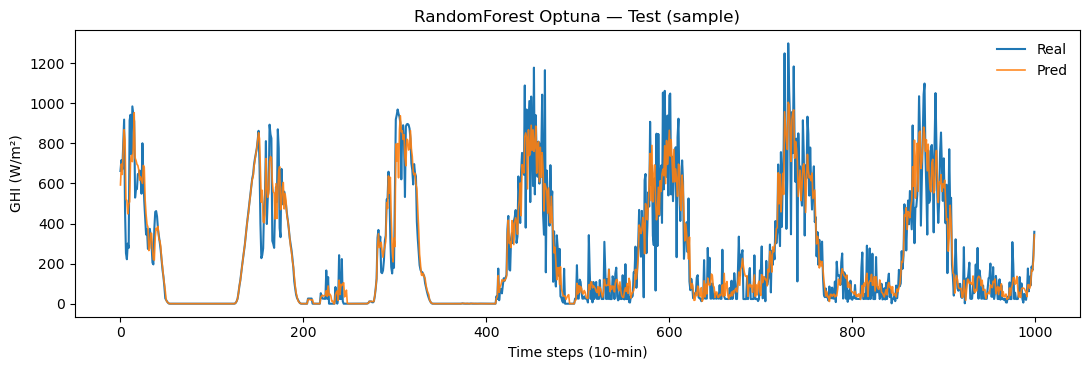

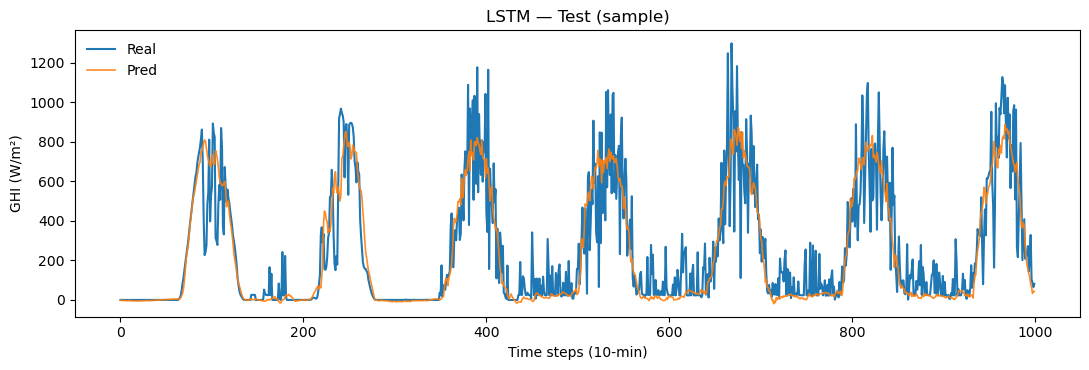

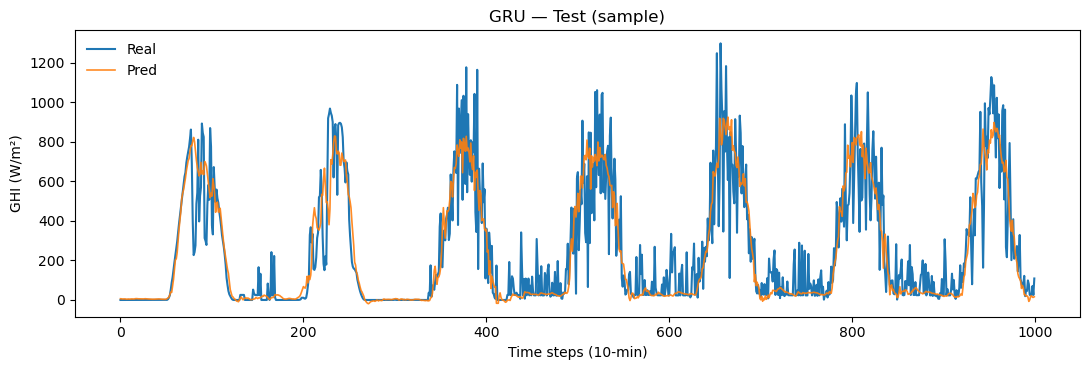

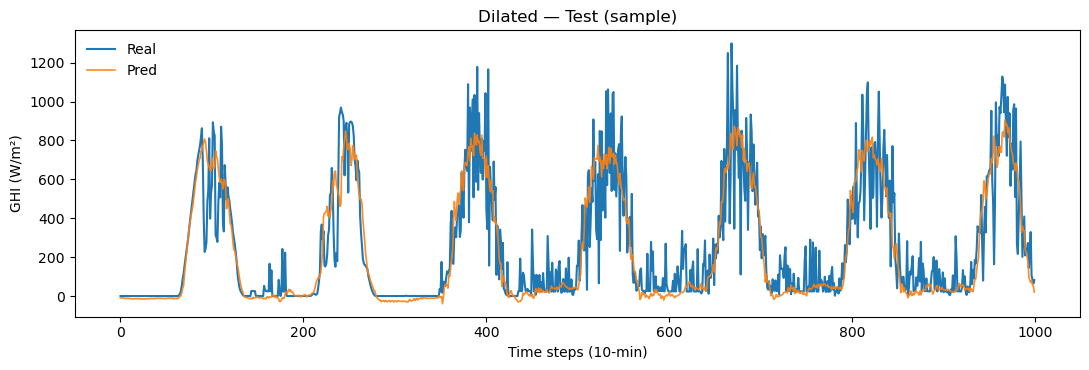

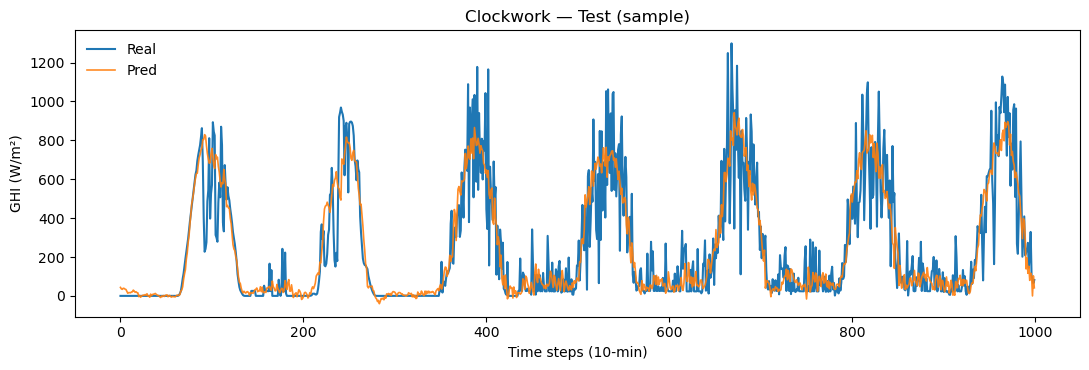

In [53]:
def plot_sample(y_true, y_pred, title, n=1000, fname=None):
    n = min(n, len(y_true))
    plt.figure(figsize=(11,3.8))
    plt.plot(y_true[:n], label="Real", lw=1.5)
    plt.plot(y_pred[:n], label="Pred", lw=1.2, alpha=0.9)
    plt.title(title); plt.xlabel("Time steps (10-min)"); plt.ylabel("GHI (W/m²)")
    plt.legend(frameon=False); plt.tight_layout()
    if fname: plt.savefig(fname, dpi=140)
    plt.show()

plot_sample(y_true_rf_opt, y_pred_rf_opt, "RandomForest Optuna — Test (sample)",
            fname=FIG_DIR / "pred_rf_opt_sample.png")

for name, (yt, yp) in {
    "LSTM": (yt_lstm, yp_lstm),
    "GRU":  (yt_gru,  yp_gru),
    "Dilated": (yt_dil, yp_dil),
    "Clockwork": (yt_cw, yp_cw),
}.items():
    plot_sample(yt, yp, f"{name} — Test (sample)",
                fname=FIG_DIR / f"pred_{name.lower()}_sample.png")

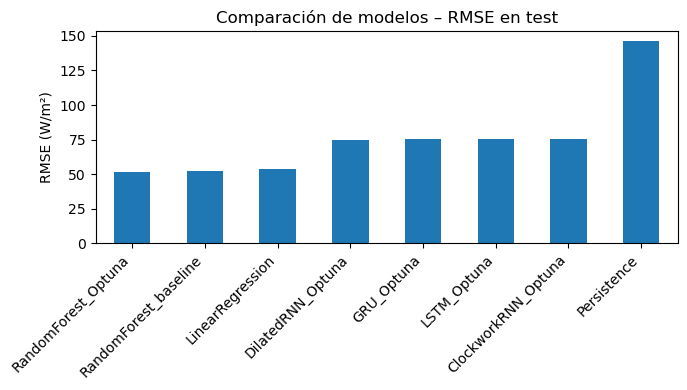

In [54]:
plt.figure(figsize=(7,4))
res_df["RMSE"].plot(kind="bar")
plt.ylabel("RMSE (W/m²)")
plt.title("Comparación de modelos – RMSE en test")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR/"models_rmse_bar.png", dpi=140)
plt.show()

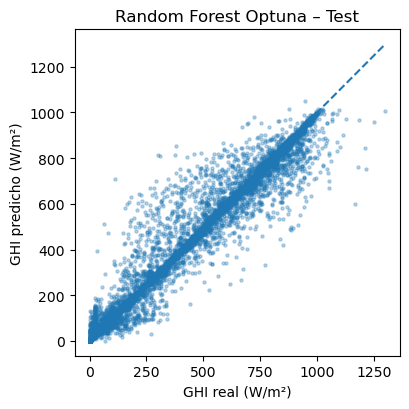

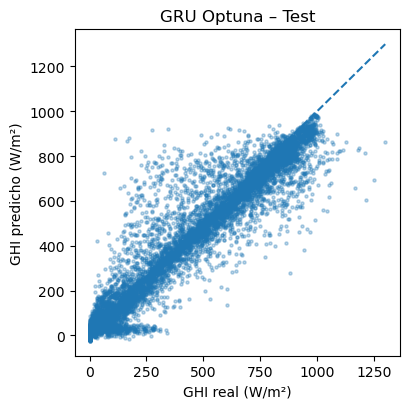

In [55]:
def scatter_pred_vs_true(y_true, y_pred, title, fname=None, lim=None):
    plt.figure(figsize=(4.2,4.2))
    plt.scatter(y_true, y_pred, s=5, alpha=0.3)
    if lim is None:
        maxv = max(np.max(y_true), np.max(y_pred))
    else:
        maxv = lim
    plt.plot([0, maxv], [0, maxv], ls="--")
    plt.xlabel("GHI real (W/m²)")
    plt.ylabel("GHI predicho (W/m²)")
    plt.title(title)
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=140)
    plt.show()

scatter_pred_vs_true(y_true_rf_opt, y_pred_rf_opt,
                     "Random Forest Optuna – Test",
                     fname=FIG_DIR/"scatter_rf.png")

scatter_pred_vs_true(yt_gru, yp_gru,
                     "GRU Optuna – Test",
                     fname=FIG_DIR/"scatter_gru.png")


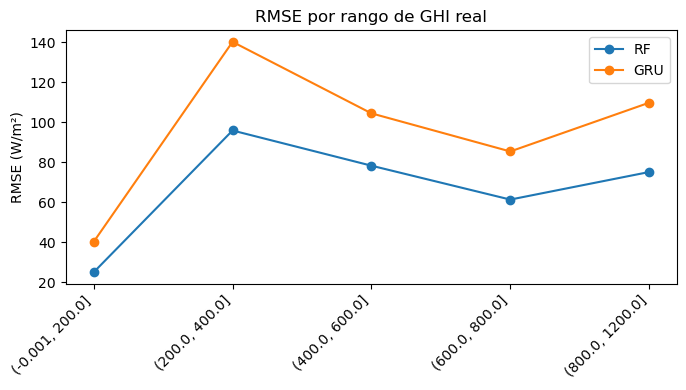

In [56]:
def binned_rmse(y_true, y_pred, bins):
    df_err = pd.DataFrame({"y": y_true, "yhat": y_pred})
    df_err["bin"] = pd.cut(df_err["y"], bins=bins, include_lowest=True)
    stats = df_err.groupby("bin").apply(
        lambda d: np.sqrt(mean_squared_error(d["y"], d["yhat"]))
    )
    return stats

bins = [0, 200, 400, 600, 800, 1200]

rf_rmse_bins = binned_rmse(y_true_rf_opt, y_pred_rf_opt, bins)
gru_rmse_bins = binned_rmse(yt_gru, yp_gru, bins)

plt.figure(figsize=(7,4))
plt.plot(rf_rmse_bins.index.astype(str), rf_rmse_bins.values, marker="o", label="RF")
plt.plot(gru_rmse_bins.index.astype(str), gru_rmse_bins.values, marker="o", label="GRU")
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE (W/m²)")
plt.title("RMSE por rango de GHI real")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR/"rmse_by_ghi_bin.png", dpi=140)
plt.show()

#### Heatmap

In [57]:
def train_fixed_arch_horizon(arch, best_trial, horizon):
    """
    Entrena un modelo de arquitectura fija (LSTM/GRU/DILATED/CLOCKWORK) para un horizonte dado,
    usando los mismos hiperparámetros del best_trial salvo horizon.
    """
    steps = best_trial.user_attrs.get("seq_len_used") or best_trial.params.get("input_steps", DEFAULT_INPUT_STEPS)
    p = best_trial.params

    Xtr_seq, ytr_seq, _ = build_seq_arrays_with_idx(X_train, y_train, df_train.index.values, steps, horizon)
    Xva_seq, yva_seq, _ = build_seq_arrays_with_idx(X_val,   y_val,   df_val.index.values,   steps, horizon)
    Xte_seq, yte_seq, idx_te = build_seq_arrays_with_idx(X_test,  y_test,  df_test.index.values,  steps, horizon)

    n_feat = Xtr_seq.shape[2]
    lr  = p.get("lr", 1e-3)
    bs  = p.get("batch", 128)
    eps = min(p.get("epochs", MAX_EPOCHS), MAX_EPOCHS)
    dropout = p.get("dropout", 0.0)

    if arch == "LSTM":
        units = p.get("hidden", 64)
        layers_n = p.get("num_layers", 1)
        model = build_lstm(steps, n_feat, units=units, layers_n=layers_n, dropout=dropout, bidir=False)
    elif arch == "GRU":
        units = p.get("hidden", 64)
        layers_n = p.get("num_layers", 1)
        model = build_gru(steps, n_feat, units=units, layers_n=layers_n, dropout=dropout, bidir=False)
    elif arch == "DILATED":
        units = p.get("hidden", 64)
        dilation = p.get("dilation", 2)
        model = build_dilated_like(steps, n_feat, units=units, dilation=dilation, dropout=dropout)
    elif arch == "CLOCKWORK":
        hidden = p.get("hidden", 120)
        modules = p.get("modules", 3)
        base_period = p.get("base_period", 1)
        model = build_clockwork(steps, n_feat, hidden=hidden, modules=modules, base_period=base_period, dropout=dropout)
    else:
        raise ValueError(arch)

    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=0),
    ]
    model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
              epochs=eps, batch_size=bs, verbose=0, callbacks=cbs)

    yhat = model.predict(Xte_seq, verbose=0).squeeze()
    y_pred = y_scaler.inverse_transform(yhat.reshape(-1,1)).ravel()
    y_true = y_scaler.inverse_transform(yte_seq.reshape(-1,1)).ravel()

    return y_true, y_pred, idx_te

In [58]:
def skill_vs_persistence_by_hour(y_true, y_pred, idx_times, horizon):
    """
    Calcula RMSE del modelo y de la persistencia por hora del día,
    y el skill = 1 - RMSE_model / RMSE_persistencia.
    Aquí la persistencia se calcula simplemente como un shift sobre y_true.
    """
    df_err = pd.DataFrame({
        "time": idx_times,
        "y_true": y_true,
        "y_pred": y_pred,
    }).set_index("time")

    # baseline de persistencia con la misma malla temporal (sobre y_true)
    base_pred = np.roll(df_err["y_true"].values, horizon)
    if len(base_pred) > horizon:
        base_pred[:horizon] = df_err["y_true"].values[horizon]
    df_err["baseline"] = base_pred

    df_err["hour"] = df_err.index.hour

    rows = []
    for h in sorted(df_err["hour"].unique()):
        sub = df_err[df_err["hour"] == h]
        if len(sub) < 10:
            continue
        rmse_model = _rmse(sub["y_true"], sub["y_pred"])
        rmse_base  = _rmse(sub["y_true"], sub["baseline"])
        skill = 1.0 - rmse_model / (rmse_base + 1e-6)
        rows.append((h, rmse_model, rmse_base, skill))
    res = pd.DataFrame(rows, columns=["hour","rmse_model","rmse_base","skill"]).set_index("hour")
    return res

In [59]:
def build_skill_matrix_for_arch(arch, best_trial, horizons=[1,3,6]):
    hours = list(range(24))
    mat_skill = np.full((len(horizons), len(hours)), np.nan)

    for i, h in enumerate(horizons):
        y_true, y_pred, idx_te = train_fixed_arch_horizon(arch, best_trial, h)
        stats = skill_vs_persistence_by_hour(y_true, y_pred, idx_te, h)
        for hr in stats.index:
            if 0 <= hr < 24:
                mat_skill[i, hr] = stats.loc[hr, "skill"]
    return np.array(horizons), np.array(hours), mat_skill

In [60]:
def plot_skill_heatmap(horizons, hours, mat_skill, title, fname=None):
    plt.figure(figsize=(10,4))
    im = plt.imshow(mat_skill, aspect="auto", origin="lower",
                    extent=[hours[0]-0.5, hours[-1]+0.5, horizons[0]-0.5, horizons[-1]+0.5])
    plt.colorbar(im, label="Skill vs persistencia")
    plt.xlabel("Hora del día (issue time)")
    plt.ylabel("Horizonte (pasos de 10 min)")
    plt.title(title)
    plt.xticks(hours)
    plt.yticks(horizons)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=160)
    plt.show()

Mejores dos RNN según RMSE: ['LSTM_Optuna', 'GRU_Optuna']
Construyendo heatmap para LSTM (clave LSTM_Optuna) ...


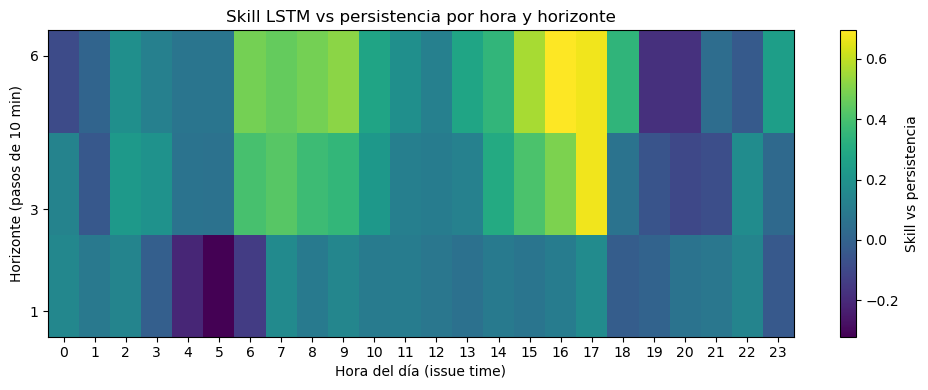

Construyendo heatmap para GRU (clave GRU_Optuna) ...


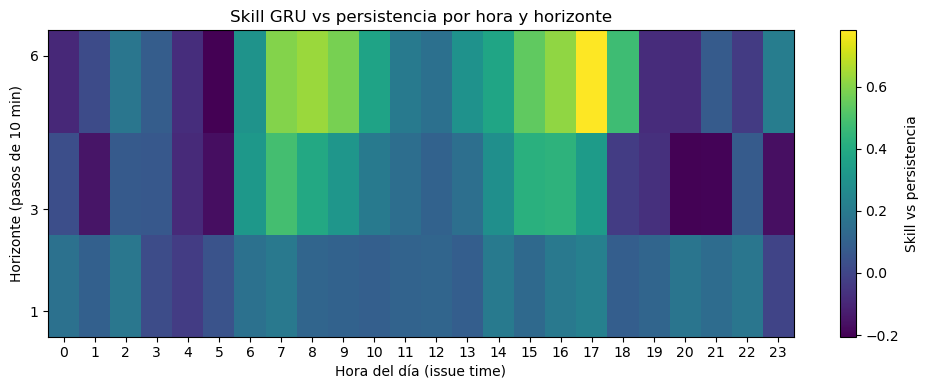

In [61]:
rnn_keys = ["LSTM_Optuna", "GRU_Optuna", "DilatedRNN_Optuna", "ClockworkRNN_Optuna"]
rnn_res = res_df.loc[[k for k in rnn_keys if k in res_df.index]]
best_two_rnns = list(rnn_res.index[:2])
print("Mejores dos RNN según RMSE:", best_two_rnns)

study_map = {
    "LSTM_Optuna": study_lstm,
    "GRU_Optuna": study_gru,
    "DilatedRNN_Optuna": study_dil,
    "ClockworkRNN_Optuna": study_cw,
}
arch_map = {
    "LSTM_Optuna": "LSTM",
    "GRU_Optuna": "GRU",
    "DilatedRNN_Optuna": "DILATED",
    "ClockworkRNN_Optuna": "CLOCKWORK",
}

HORIZONS = [1, 3, 6]

for key in best_two_rnns:
    arch = arch_map[key]
    study = study_map[key]
    print(f"Construyendo heatmap para {arch} (clave {key}) ...")
    horizons_arr, hours_arr, mat_skill = build_skill_matrix_for_arch(arch, study.best_trial, HORIZONS)
    plot_skill_heatmap(horizons_arr, hours_arr, mat_skill,
                       f"Skill {arch} vs persistencia por hora y horizonte",
                       fname=FIG_DIR/f"heatmap_skill_{arch.lower()}.png")

## MLFlow

In [62]:
if USE_MLFLOW:
    print("Registrando resultados en MLflow...")
    mlflow.set_experiment("ghi-tabular-rnns")

    with mlflow.start_run(run_name="final_tabular_models"):
        # Hiperparámetros
        mlflow.log_params({f"LSTM_{k}": v for k,v in study_lstm.best_trial.params.items()})
        mlflow.log_params({f"GRU_{k}": v for k,v in study_gru.best_trial.params.items()})
        mlflow.log_params({f"DIL_{k}": v for k,v in study_dil.best_trial.params.items()})
        mlflow.log_params({f"CW_{k}": v for k,v in study_cw.best_trial.params.items()})
        mlflow.log_params({f"RF_{k}": v for k,v in study_rf.best_trial.params.items()})

        # Métricas
        for model_name, mets in results.items():
            for m_name, m_val in mets.items():
                mlflow.log_metric(f"{model_name}_{m_name}", float(m_val))

        # Artifacts
        mlflow.log_artifact(ART_DIR/"tabular_results_optuna_keras.json")
        mlflow.log_artifact(ART_DIR/"tabular_best_params_keras.json")

        for fig_name in [
            "pred_rf_opt_sample.png",
            "pred_lstm_sample.png",
            "pred_gru_sample.png",
            "pred_dilated_sample.png",
            "pred_clockwork_sample.png",
            "models_rmse_bar.png",
            "scatter_rf.png",
            "scatter_gru.png",
            "rmse_by_ghi_bin.png",
        ]:
            fig_path = FIG_DIR/fig_name
            if fig_path.exists():
                mlflow.log_artifact(fig_path)

        for key in best_two_rnns:
            arch = arch_map[key]
            fname = FIG_DIR/f"heatmap_skill_{arch.lower()}.png"
            if fname.exists():
                mlflow.log_artifact(fname)

    print("MLflow logging completado.")